In [1]:
from phastphase.retrieval_jax import refine, retrieve
%load_ext autoreload
%autoreload 2

from phastphase.retrieval_jax.alternative_methods._gradient_flows import (
    wirtinger_flow, amplitude_flow, truncated_amplitude_flow, truncated_wirtinger_flow)

import jax.numpy as jnp
import cv2 as cv
import jax
jax.config.update("jax_enable_x64", True)
jax.config.update('jax_default_device', jax.devices("cpu")[0])

In [4]:
from phastphase.data_generation.data_generation_utils import *

Opened the image: Pillars_of_Creation.png
Image size: (216, 125, 3)


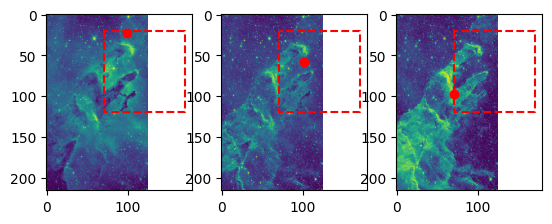

In [ ]:
path = ""
filename = "Pillars_of_Creation.png"

image = cv.imread(path + filename, cv.IMREAD_GRAYSCALE)
image = cv.resize(image,(0,0),fx=.25,fy=.25)
pillars = np.asarray(image)

print('Opened the image: %s'%filename)
print('Image size: %s'%str(np.shape(pillars)))

fig,ax = plt.subplots(1,3)
for i in range(3):
  ax[i].imshow(pillars[:,:,i])
  s = 50
  cenx,ceny = [120,70]
  ax[i].plot([cenx-s,cenx-s,cenx+s,cenx+s,cenx-s],[ceny-s,ceny+s,ceny+s,ceny-s,ceny-s],'--r')
  argy,argx = np.unravel_index(np.argmax(pillars[ceny-s:ceny+s,cenx-s:cenx+s,i]),
                               np.shape(pillars[ceny-s:ceny+s,cenx-s:cenx+s,i]))
  ax[i].plot(argx+cenx-s,argy+ceny-s,'or')

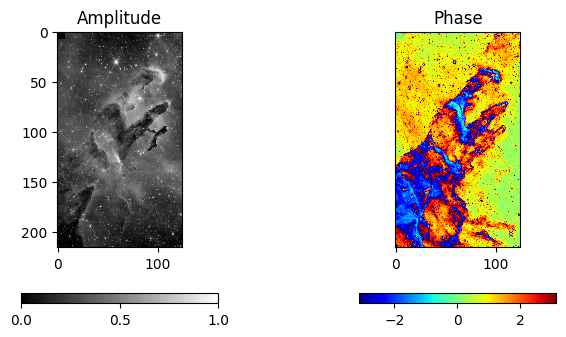

(216, 125)
(432, 250)
11548440.009078689
11548440.009078695


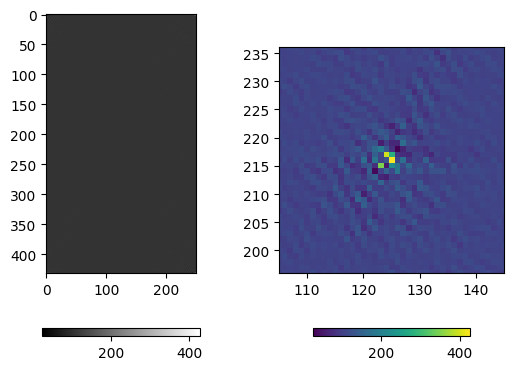

In [6]:
real_part = pillars[:, :, 0] / np.amax(np.abs(pillars[:, :, 0]))
imag_part = pillars[:, :, 2] / np.amax(np.abs(pillars[:, :, 2]))
complex_img = real_part* np.exp(1j * imag_part * np.pi * 2)
near_field = complex_img.copy()

#make a bright spot
near_field[0,0]= np.sum(near_field) + 1

plot_all(near_field,s=4)

y = np.abs(np.fft.fft2(near_field, s=np.array(np.shape(near_field))*2))**2
y = y / (np.shape(y)[0]*np.shape(y)[1])

fig,ax = plt.subplots(1,2)
ax0 = ax[0].imshow(y, cmap = 'gray');
ax1 = ax[1].imshow((np.fft.fftshift(y)))
ax[1].set_xlim([np.shape(y)[1]/2 - 20,np.shape(y)[1]/2 + 20])
ax[1].set_ylim([np.shape(y)[0]/2 - 20,np.shape(y)[0]/2 + 20])
fig.colorbar(ax1, ax=ax[1],  shrink=0.7, location='bottom')
fig.colorbar(ax0, ax=ax[0],  shrink=0.7,location='bottom')

print(np.shape(near_field))
print(np.shape(y))

print(np.sum(y))
print(np.sum(np.abs(near_field)**2))

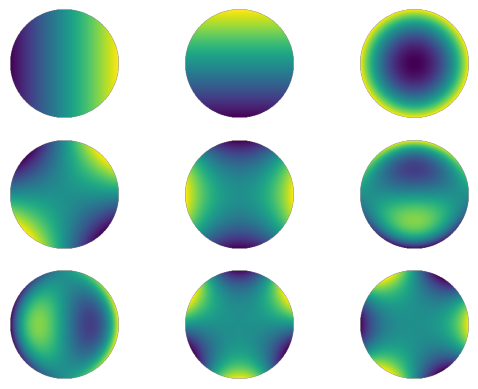

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from zernike import RZern

cart = RZern(6)
L, K = 200, 250
ddx = np.linspace(-1.0, 1.0, K)
ddy = np.linspace(-1.0, 1.0, L)
xv, yv = np.meshgrid(ddx, ddy)
cart.make_cart_grid(xv, yv)

c = np.zeros(cart.nk)
plt.figure(1)
for i in range(1, 10):
    plt.subplot(3, 3, i)
    c *= 0.0
    c[i] = 1.0
    Phi = cart.eval_grid(c, matrix=True)
    plt.imshow(Phi, origin='lower', extent=(-1, 1, -1, 1))
    plt.axis('off')

plt.show()

(512, 512)
(512, 512)
(512, 512)


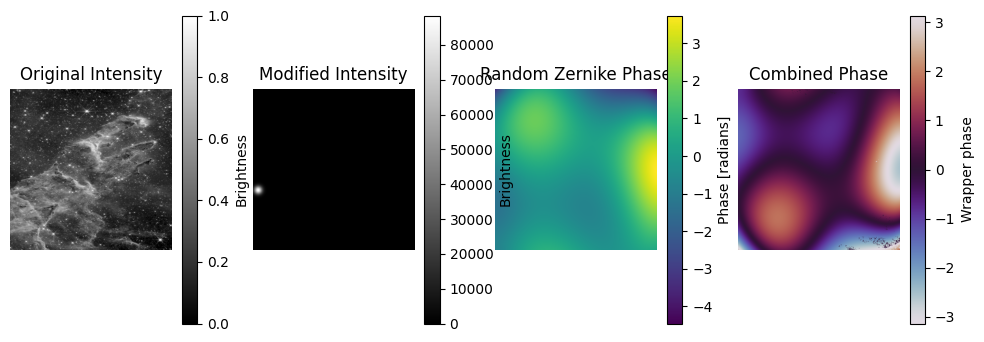

In [ ]:
from phastphase.data_generation import data_generation_utils
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt

# Generate unit disk mask
N = 512
y, x = np.linspace(-1, 1, N), np.linspace(-1, 1, N)
X, Y = np.meshgrid(x, y)
rho = np.sqrt(X**2 + Y**2)
theta = np.arctan2(Y, X)
mask = rho <= 1

# Load image as near field intensity
filename = "Pillars_of_Creation.png"
image = cv.imread(filename, cv.IMREAD_GRAYSCALE)
image = cv.resize(image,(N,N))
intensity = np.asarray(image)
# intensity = intensity / np.max(intensity)

intensity_orignal = intensity.astype(float).copy()

# plt.imshow(pillars, cmap='gray', origin='lower') 
data_generation_utils.add_gaussian_spot(intensity)
# data_generation_utils.add_heaviside_spot(intensity)

# Generate phase map
# phase_map = data_generation_utils.generate_zernike_phase_map(N, strength=5, aperature="circular")
phase_map = data_generation_utils.generate_zernike_phase_map((N, N), strength=5, decay=0.05, aperature="cropped")

# Combine into complex field
E = np.sqrt(intensity) * np.exp(1j * phase_map)

fig, ax = plt.subplots(1, 4, figsize=(12, 4))

im = ax[0].imshow(intensity_orignal, cmap='gray')
ax[0].set_title("Original Intensity")
fig.colorbar(im, label='Brightness', ax=ax[0])
ax[0].axis('off')

im = ax[1].imshow(intensity, cmap='gray')
ax[1].set_title("Modified Intensity")
fig.colorbar(im, label='Brightness', ax=ax[1])
ax[1].axis('off')

im = ax[2].imshow(phase_map, origin='lower')#, extent=(-1, 1, -1, 1))
ax[2].set_title("Random Zernike Phase")
fig.colorbar(im, label='Phase [radians]', ax=ax[2])
ax[2].axis('off')

im = ax[3].imshow(np.angle(E), cmap='twilight')
ax[3].set_title("Combined Phase")
fig.colorbar(im, label='Wrapper phase', ax=ax[3])
ax[3].axis('off')

plt.show()

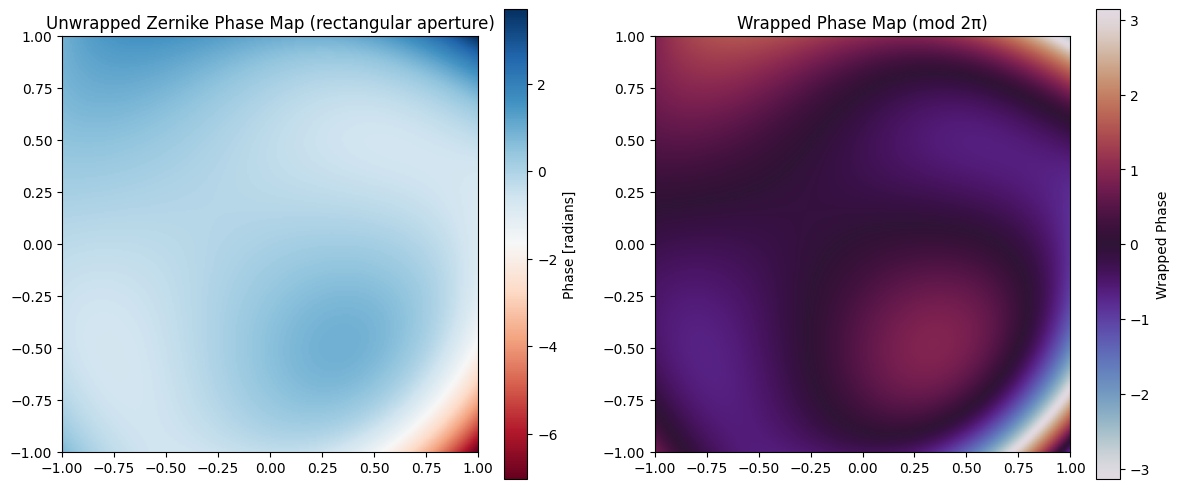

In [7]:
import numpy as np
import matplotlib.pyplot as plt
from math import factorial

# ============================================================
# 1. Define Zernike polynomial (radial part)
# ============================================================
def R_nm(n, m, rho):
    """Radial part of Zernike polynomial"""
    R = np.zeros_like(rho)
    m = abs(m)
    for k in range((n - m)//2 + 1):
        c = ((-1)**k * factorial(n - k)) / (
            factorial(k) * factorial((n + m)//2 - k) * factorial((n - m)//2 - k)
        )
        R += c * rho**(n - 2*k)
    return R

# ============================================================
# 2. Define full Zernike mode
# ============================================================
def zernike(n, m, rho, theta):
    """Return Zernike mode Z_n^m on unit disk"""
    if m >= 0:
        return R_nm(n, m, rho) * np.cos(m * theta)
    else:
        return R_nm(n, -m, rho) * np.sin(-m * theta)

# ============================================================
# 3. Generate rectangular grid and map Zernikes
# ============================================================
N = 256
x = np.linspace(-1, 1, N)
y = np.linspace(-1, 1, N)
X, Y = np.meshgrid(x, y)

rho = np.sqrt(X**2 + Y**2)
theta = np.arctan2(Y, X)
mask = rho <= 1  # circular aperture

# ============================================================
# 4. Define physical aberrations (Zernike terms)
# ============================================================
# noll indices 2..14 correspond roughly to:
# tilt x, tilt y, defocus, astigmatism, coma, trefoil, spherical
zernike_terms = [
    (2, -2), (2, 0), (2, 2),   # astigmatism, defocus
    (3, -1), (3, 1),           # vertical/horizontal coma
    (4, 0), (4, 2), (4, -2)    # spherical, secondary astigmatism
]

rng = np.random.default_rng()
coeffs = rng.normal(scale=0.3, size=len(zernike_terms))  # random amplitudes (radians)

# ============================================================
# 5. Construct random realistic phase map
# ============================================================
phase = np.zeros_like(X)
for (nm, c) in zip(zernike_terms, coeffs):
    n, m = nm
    # Z = np.zeros_like(X)
    # Z[mask] = zernike(n, m, rho[mask], theta[mask])
    # phase += c * Z
    phase += c * zernike(n, m, rho, theta)


# Optional: wrap to [-π, π]
wrapped_phase = np.angle(np.exp(1j * phase))

# ============================================================
# 6. Plot results
# ============================================================
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.imshow(phase, cmap='RdBu', origin='lower', extent=(-1, 1, -1, 1))
plt.colorbar(label='Phase [radians]')
plt.title('Unwrapped Zernike Phase Map (rectangular aperture)')

plt.subplot(1, 2, 2)
plt.imshow(wrapped_phase, cmap='twilight', origin='lower', extent=(-1, 1, -1, 1))
plt.colorbar(label='Wrapped Phase')
plt.title('Wrapped Phase Map (mod 2π)')

plt.tight_layout()
plt.show()


In [2]:
from phastphase.retrieval_jax import refine, retrieve
%load_ext autoreload
%autoreload 2

In [3]:
import jax.numpy as jnp

normalized_comp = E/jnp.linalg.vector_norm(E)
oversample = 2
schwarz_comp = normalized_comp.at[0,0].set(10*jnp.size(E))
far_field_shape = (E.shape[0]*oversample, E.shape[1]*oversample)
y = jnp.abs(jnp.fft.fft2(schwarz_comp, s=far_field_shape, norm="ortho"))**2

mask = jnp.ones_like(E)
x_out, val = retrieve(
    y,
    mask,
    max_iters=1000,
    descent_method=0,
    grad_tolerance=1e-14
    #winding_guess=(0, 0),
)

print(jnp.linalg.vector_norm(x_out - schwarz_comp) / jnp.linalg.vector_norm(schwarz_comp))


Using winding numbers: (0, 0)
Using winding numbers: (0, 0)
0.9720491


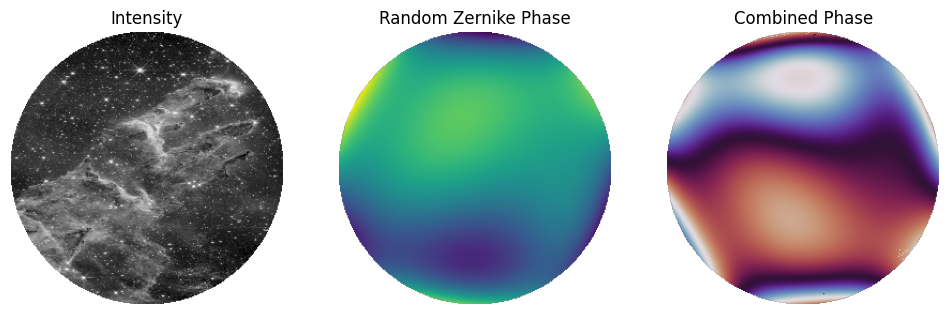

In [1]:
from phastphase.data_generation import data_generation_utils
import numpy as np
import matplotlib.pyplot as plt

filename = "Pillars_of_Creation.png"
phase_map, combined_map = data_generation_utils.image_with_random_zernike_phase(filename, 256)

fig, ax = plt.subplots(1, 3, figsize=(12, 4))

ax[0].imshow(np.abs(combined_map)**2, cmap='gray')
ax[0].set_title("Intensity")
ax[0].axis('off')

ax[1].imshow(phase_map, origin='lower', extent=(-1, 1, -1, 1))
ax[1].set_title("Random Zernike Phase")
ax[1].axis('off')

ax[2].imshow(np.angle(combined_map), cmap='twilight')
ax[2].set_title("Combined Phase")
ax[2].axis('off')

plt.show()

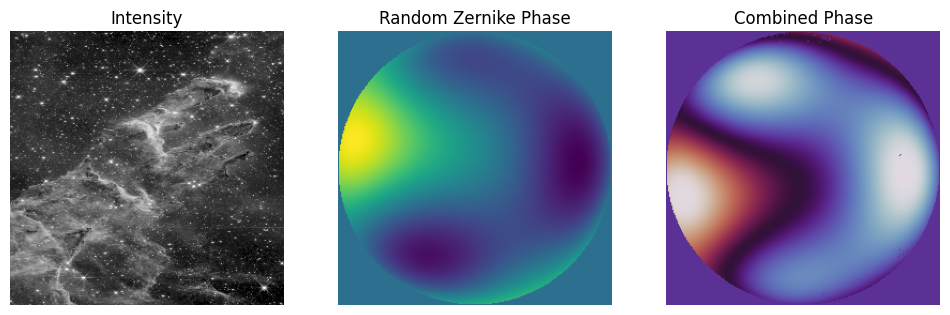

In [2]:
fig, ax = plt.subplots(1, 3, figsize=(12, 4))

ax[0].imshow(intensity, cmap='gray')
ax[0].set_title("Intensity")
ax[0].axis('off')

ax[1].imshow(phase_map, origin='lower', extent=(-1, 1, -1, 1))
ax[1].set_title("Random Zernike Phase")
ax[1].axis('off')

ax[2].imshow(np.angle(E), cmap='twilight')
ax[2].set_title("Combined Phase")
ax[2].axis('off')

plt.show()

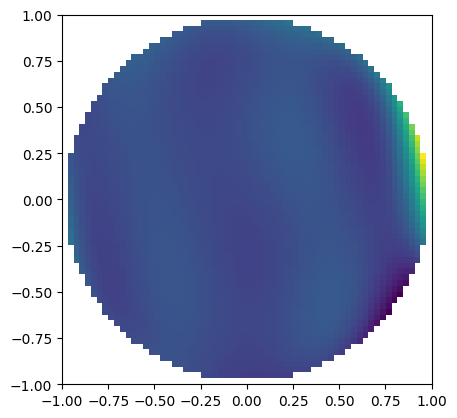

In [13]:
import zernike
import numpy as np
size = 64
x, y = np.linspace(-1.0, 1.0, size), np.linspace(-1.0, 1.0, size)
X, Y = np.meshgrid(x, y)
rho = np.sqrt(X**2 + Y**2)
mask = rho <= 1

# Initialize the Zernike object
cart = zernike.RZern(6)
cart.make_cart_grid(X, Y)

coeffs = np.ones(cart.nk)
phase = cart.eval_grid(coeffs, matrix=True)
plt.imshow(phase, origin='lower', extent=(-1, 1, -1, 1))
plt.show()
# print(phase)

[[nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 ...
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]]
[[nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 ...
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]]
[[nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 ...
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]]
[[nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 ...
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]]
[[nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 ...
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]]
[[nan nan nan ... nan nan nan]
 [nan nan

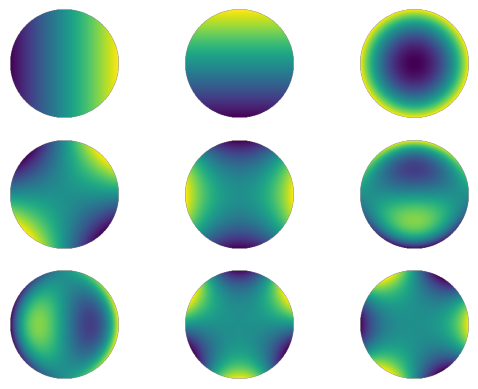

In [11]:
import numpy as np
import matplotlib.pyplot as plt
from zernike import RZern

cart = RZern(6)
L, K = 200, 250
ddx = np.linspace(-1.0, 1.0, K)
ddy = np.linspace(-1.0, 1.0, L)
xv, yv = np.meshgrid(ddx, ddy)
cart.make_cart_grid(xv, yv)

c = np.zeros(cart.nk)
plt.figure(1)
for i in range(1, 10):
    plt.subplot(3, 3, i)
    c *= 0.0
    c[i] = 1.0
    Phi = cart.eval_grid(c, matrix=True)
    print(Phi)
    plt.imshow(Phi, origin='lower', extent=(-1, 1, -1, 1))
    plt.axis('off')

plt.show()

In [ ]:
phase_map

array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]], shape=(256, 256))

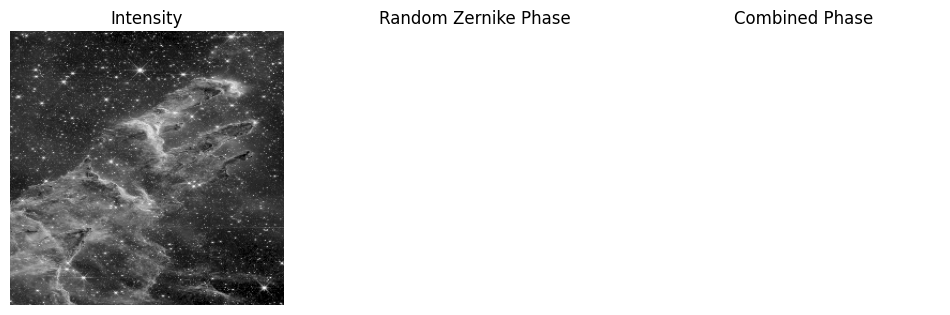

In [3]:
fig, ax = plt.subplots(1, 3, figsize=(12, 4))

ax[0].imshow(intensity, cmap='gray')
ax[0].set_title("Intensity")
ax[0].axis('off')

ax[1].imshow(phase_map, cmap='twilight')
ax[1].set_title("Random Zernike Phase")
ax[1].axis('off')

ax[2].imshow(np.angle(E), cmap='twilight')
ax[2].set_title("Combined Phase")
ax[2].axis('off')

plt.show()

[[-1.         -0.71428571 -0.42857143 -0.14285714  0.14285714  0.42857143
   0.71428571  1.        ]
 [-1.         -0.71428571 -0.42857143 -0.14285714  0.14285714  0.42857143
   0.71428571  1.        ]
 [-1.         -0.71428571 -0.42857143 -0.14285714  0.14285714  0.42857143
   0.71428571  1.        ]
 [-1.         -0.71428571 -0.42857143 -0.14285714  0.14285714  0.42857143
   0.71428571  1.        ]
 [-1.         -0.71428571 -0.42857143 -0.14285714  0.14285714  0.42857143
   0.71428571  1.        ]
 [-1.         -0.71428571 -0.42857143 -0.14285714  0.14285714  0.42857143
   0.71428571  1.        ]
 [-1.         -0.71428571 -0.42857143 -0.14285714  0.14285714  0.42857143
   0.71428571  1.        ]
 [-1.         -0.71428571 -0.42857143 -0.14285714  0.14285714  0.42857143
   0.71428571  1.        ]]
[[-1.         -1.         -1.         -1.         -1.         -1.
  -1.         -1.        ]
 [-0.71428571 -0.71428571 -0.71428571 -0.71428571 -0.71428571 -0.71428571
  -0.71428571 -0.7142857

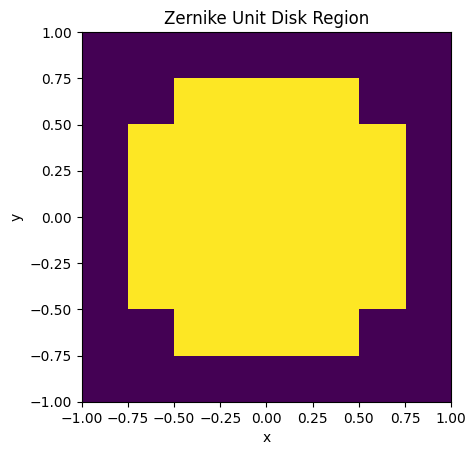

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

N = 8
x = np.linspace(-1, 1, N)
y = np.linspace(-1, 1, N)
X, Y = np.meshgrid(x, y)
rho = np.sqrt(X**2 + Y**2)
mask = rho <= 1

plt.imshow(mask, extent=[-1, 1, -1, 1])
plt.title("Zernike Unit Disk Region")
plt.xlabel("x")
plt.ylabel("y")
plt.show()

[[0.  0.5 1. ]
 [0.  0.5 1. ]]
[[0. 0. 0.]
 [1. 1. 1.]]


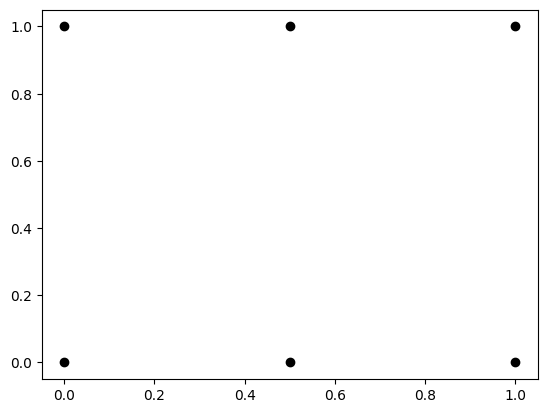

In [12]:
nx, ny = (3, 2)
x = np.linspace(0, 1, nx)
y = np.linspace(0, 1, ny)
xv, yv = np.meshgrid(x, y)
print(xv)
print(yv)
xv = [0.,  0.5, 1., 0.,  0.5, 1. ]
yv = [0,0,0,1,1,1]
plt.plot(xv, yv, marker='o', color='k', linestyle='none')
plt.show()